## Arbeitsschritte

Was ich erwarte:
* Daten laden ###
* Erste “Insights”, d.h. explorative Datenanalayse inkl. einiger Charts (Verteilungen, erste Korrelationen etc.,) um die Daten zu verstehen
* Datacleaning ###
* Feature Engineering ###
* Modellbildung
* alle klassischen Modelle, die Sie bisher kennen
* XGBoost ###
* Neuronales Netz ###
* Für die besten Modelle: Hyperparameter Tuning (GridSearchCV) ###
* ggf. auch Mischung verschiedener Modelle (Ensemble) ###
* Feature Importance / Permutation Importance
* Eine Submission soll für die test.csv erstellt werden und bei Kaggle hochgeladen werden
* Am Ende zwei reißerische Grafiken mit jeweils einer Einsicht auf Basis der KI-Modelle (storytelling beachten!)
* Für jedes Kapitel eine kurze (gerne stichwortartige) Zusammenfassung im Notebook, was gemacht bzw. was noch so versucht wurde, jedoch nicht geklappt hat und welche Erkentnisse im Kapitel gesammelt wurden.


Organisatorisches:

* Abgabe
* Form eines Git-Links zu Ihrem Projekt
* Montag 08.04.. , 23:59 Uhr
* Sie haben in meinem Unterricht zwei Termine Zeit für diesen Teil (12.02. und 19.02.)

# Mies viele Kommentare

# One Hot Encoden ???

# Korrelationschart fehlt

# auf rmspe score bei ML umstellen

# bei prediction mit NN prediction mit e^x verrechnen wegen log(sales)

# Daten Import

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from best_params import make
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.svm import SVR
import torch
import torch.nn as nn
import json
from sklearn.metrics import r2_score
import seaborn as sns
import xgboost
import numpy as np

df = pd.read_csv("train.csv")
store_df = pd.read_csv("store.csv")

# Zusatzinformation der einzelnen Geschäfte in den Haupt DataFrame laden 
big_df = df.merge(store_df, on="Store", how="left")
store_df

C:\Users\OstertagO\AppData\Local\Temp\ipykernel_18944\2831382316.py:22: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("train.csv")


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


## EDA

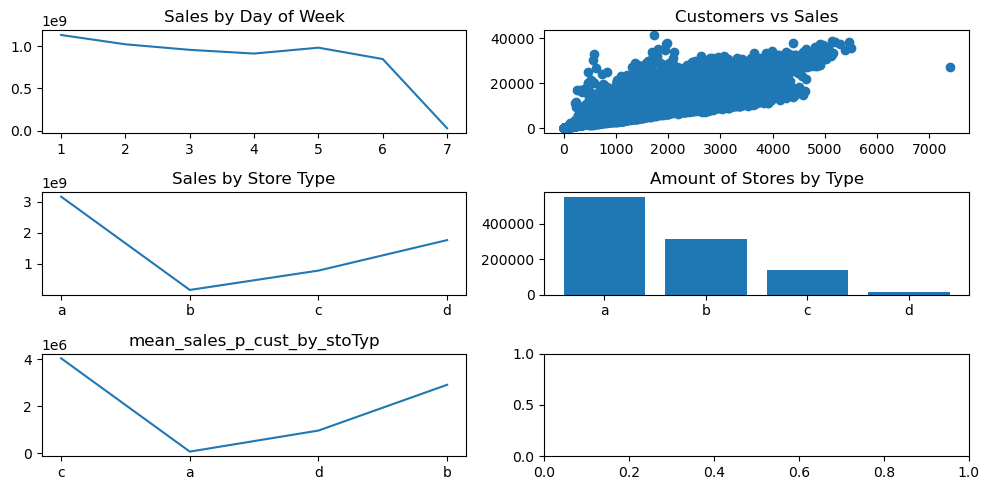

In [22]:
fig, axs = plt.subplots(3, 2, figsize=(10, 5))

# Plot 1: Sales by Day of WeekVerkäufe nach Wochentag 
s_b_d = big_df["Sales"].groupby(big_df["DayOfWeek"]).sum()
axs[0, 0].plot(s_b_d)
axs[0, 0].set_title('Sales by Day of Week')

# Plot 2: Punktwolke mit Vergleich zwischen Customers und Sales 
axs[0, 1].scatter(big_df["Customers"], big_df["Sales"])
axs[0, 1].set_title('Customers vs Sales')

# Plot 3: Verkäufe nach Geschäftsart 
sales_by_storeType = big_df["Sales"].groupby(big_df["StoreType"]).sum()
axs[1, 0].plot(sales_by_storeType)
axs[1, 0].set_title('Sales by Store Type')

# Plot 4: Anzahl der Geschäfte nach Typ 
amt_stores_by_type = big_df["StoreType"].value_counts()
axs[1, 1].bar(["a", "b", "c", "d"], amt_stores_by_type)
axs[1, 1].set_title('Amount of Stores by Type')

# Durchschnittliche Käufe pro Kunde
sales_per_customer = big_df["Sales"] / big_df["Customers"]
big_df["sales_per_customer"] = sales_per_customer

# Durchschnittliche Käufe pro Kunde nach Store Type
m_sales_customer_by_st = big_df["sales_per_customer"].groupby(big_df["StoreType"]).sum().values.tolist()
axs[2, 0].plot(big_df["StoreType"].unique(), m_sales_customer_by_st)
axs[2, 0].set_title("mean_sales_p_cust_by_stoTyp")

# Grafiken ausgeben
plt.tight_layout()
plt.show()

## Datacleaning

In [23]:
def apply_cleaning(df):
    # Leere Werte der Spalte Competition Distance mit 0 füllen
    df["CompetitionDistance"] = df["CompetitionDistance"].fillna(0)
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    comp_zeros = df["CompetitionDistance"] == 0
    df["CompetitionOpenSinceMonth"][comp_zeros] = 0
    df["CompetitionOpenSinceYear"][comp_zeros] = 0
    df = df.dropna(axis=0)

    return df

# Die Bereinigung auf den Haupt DataFrame anwenden 
big_df = apply_cleaning(big_df)
big_df.head(5)

C:\Users\OstertagO\AppData\Local\Temp\ipykernel_18944\3747568739.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CompetitionOpenSinceMonth"][comp_zeros] = 0
C:\Users\OstertagO\AppData\Local\Temp\ipykernel_18944\3747568739.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CompetitionOpenSinceYear"][comp_zeros] = 0


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,sales_per_customer
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",10.126675
10,11,5,2015-07-31,10457,1236,1,1,0,1,a,c,960.0,11.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct",8.460356
13,14,5,2015-07-31,6544,710,1,1,0,1,a,a,1300.0,3.0,2014.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct",9.216901
14,15,5,2015-07-31,9191,766,1,1,0,1,d,c,4110.0,3.0,2010.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",11.998695


## Feature Engineering

In [24]:
def do_fe(df):
    
    to_drop = ["Date", "Store"]
    df = df.drop(to_drop, axis=1)

    df["CompetitionDistance"] = df["CompetitionDistance"].astype(int)
    df["CompetitionOpenSinceMonth"] = df["CompetitionOpenSinceMonth"].astype(int)
    df["CompetitionOpenSinceYear"] = df["CompetitionOpenSinceYear"].astype(int)
    df["Promo2SinceWeek"] = df["Promo2SinceWeek"].astype(int)
    df["Promo2SinceYear"] = df["Promo2SinceYear"].astype(int)

    #big_df["promo2week_bool"] = big_df["Promo2SinceWeek"] == big_df["Promo2SinceWeek"].isna()

    # Die Storytypen in eine numerischen Skalierung überführen 
    store_type_dict = {"a": 0, "b": 1, "c": 2, "d": 3}
    df["StoreType"] = df["StoreType"].map(store_type_dict)

    assortment_dict = {"a": 0, "b": 1, "c": 2}
    df["Assortment"] = df["Assortment"].map(assortment_dict)

    # Die Spalte Promo Intervall enthält 3 Unique Werte. 
    # Um zu verhindern, Das eine Wertigkeit erlernt wird, haben wir uns dazu entschieden Für jeden Monat eine Spalte anzulegen.
    # Alle Spalten werden bei Erstellung mit Nullen gefüllt. Dann wird über die Elemente der Spalte PromoIntervall itteriert und je nach einem der 3 Fälle, die entsprechenden Zellen der entsprechenden Spalten mit Einsen gefüllt (Beim Januar also die Zellen der Spalten Januar April, Juli und Oktober).
    df["jan"] = 0
    df["feb"] = 0
    df["mar"] = 0
    df["apr"] = 0
    df["may"] = 0
    df["jun"] = 0
    df["jul"] = 0
    df["aug"] = 0
    df["sep"] = 0
    df["oct"] = 0
    df["nov"] = 0
    df["dec"] = 0

    for index, row in df.iterrows():
        start = row["PromoInterval"].split(",")[0]
        match start:
            case "Jan":
                df.at[index, "jan"] = 1
                df.at[index, "apr"] = 1
                df.at[index, "jul"] = 1
                df.at[index, "oct"] = 1

            case "Feb":
                df.at[index, "feb"] = 1
                df.at[index, "may"] = 1
                df.at[index, "aug"] = 1
                df.at[index, "nov"] = 1

            case "Mar":
                df.at[index, "mar"] = 1
                df.at[index, "jun"] = 1
                df.at[index, "sep"] = 1
                df.at[index, "dec"] = 1

    
    df = df.drop("PromoInterval", axis=1)   

    # Alle Spaltentitel in lower Snake Case verwandeln
    for col in df.columns:
        col_n = re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower()
        df.rename(columns={col: col_n}, inplace=True)

    holiday_map = {"0": 0, "a": 1, "b": 2, "c": 3, 0: 4}
    df["state_holiday"] = df["state_holiday"].map(holiday_map)

    # Da in diesen Spalten im Vergleich zu den anderen des DataFrames sehr hohe Werte vorkommen, haben wir uns dazu entschlossen, den Logarithmus der jeweiligen Spalte zu ziehen, damit die Modelle vernünftig lernen können
    df["sales"] = np.log(df["sales"])
    df["customers"] = np.log(df["customers"])
    df["competition_distance"] = np.log(df["competition_distance"])

    return df

big_df = do_fe(big_df)
big_df

c:\Users\OstertagO\AppData\Local\anaconda3\envs\fa22b\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
1,5,8.710125,6.437752,1,1,0,1,0,0,6.345636,...,0,1,0,0,1,0,0,1,0,0
2,5,9.025696,6.710523,1,1,0,1,0,0,9.556055,...,0,1,0,0,1,0,0,1,0,0
10,5,9.255027,7.119636,1,1,0,1,0,2,6.866933,...,0,1,0,0,1,0,0,1,0,0
13,5,8.786304,6.565265,1,1,0,1,0,0,7.170120,...,0,1,0,0,1,0,0,1,0,0
14,5,9.125980,6.641182,1,1,0,1,3,2,8.321178,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016084,3,7.942362,5.888878,1,0,0,1,2,2,5.799093,...,0,0,1,0,0,1,0,0,1,0
1016085,3,8.536800,6.429719,1,0,0,1,0,2,8.581107,...,0,1,0,0,1,0,0,1,0,0
1016086,3,8.282736,6.263398,1,0,0,1,0,0,7.244228,...,0,1,0,0,1,0,0,1,0,0
1016088,3,8.428581,6.095825,1,0,0,1,2,0,8.157657,...,0,1,0,0,1,0,0,1,0,0


In [25]:
#print(big_df["PromoInterval"].unique()) # im 3-Monats Intervall
big_df.columns

Index(['day_of_week', 'sales', 'customers', 'open', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'sales_per_customer', 'jan',
       'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov',
       'dec'],
      dtype='object')

In [26]:
#corr = big_df.corr()
#fig, ax = plt.subplots(figsize=(10, 10))
# reduce font size
#sns.heatmap(corr, annot=True, fmt=".2f")
#plt.show()

In [27]:
# 
X = big_df.drop("sales", axis=1)
y = big_df["sales"]

X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with 0 (or any other number you want)
X.fillna(0, inplace=True)

scaler=StandardScaler()
scaler.fit(X)
x_scaled=scaler.transform(X)

x_scaled_df = pd.DataFrame(x_scaled, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(x_scaled_df, y, test_size=0.2, random_state=42)

# Die Funktion make kann aufgerufen werden, um die optimalen Parameter für die Machine Learning-Verfahren zu errechnen und in eine json-Datei zu speichern
#make(X_train, y_train)
# Die errechneten Parameter aus der json-Datei laden
params_f = json.load(open("best_params.json", "r"))

def make_voting(X_train, y_train, X_test, y_test):
    # Das jeweilige Dictionary mit dem Parametern für das jeweilige Verfahren herausnehmen
    best_knn_params = params_f["knn"]
    best_tree_params = params_f["tree"]
    best_forest_params = params_f["forest"]
    best_svm_params = params_f["svm"]
    best_lin_reg_params = params_f["lin_reg"]
    best_xg_params = params_f["xg"]

    # Je Parameter Dictionary ein Vorhersagemodell aus diesen Daten bauen
    knn = KNeighborsRegressor(n_neighbors=best_knn_params["kneighborsregressor__n_neighbors"],
                             weights=best_knn_params["kneighborsregressor__weights"],
                             algorithm=best_knn_params["kneighborsregressor__algorithm"])
    tree = DecisionTreeRegressor(max_depth=best_tree_params["decisiontreeregressor__max_depth"],
                                 min_samples_split=best_tree_params["decisiontreeregressor__min_samples_split"],
                                 min_samples_leaf=best_tree_params["decisiontreeregressor__min_samples_leaf"])
    forest = RandomForestRegressor(n_estimators=best_forest_params["randomforestregressor__n_estimators"],
                                   max_depth=best_forest_params["randomforestregressor__max_depth"],
                                   min_samples_split=best_forest_params["randomforestregressor__min_samples_split"],
                                   min_samples_leaf=best_forest_params["randomforestregressor__min_samples_leaf"])
    svm = SVR(kernel=best_svm_params["svr__kernel"],
             degree=best_svm_params["svr__degree"],
             C=best_svm_params["svr__C"])
    lin_reg = LinearRegression(fit_intercept=best_lin_reg_params["linearregression__fit_intercept"])

    xg = xgboost.XGBRegressor(learning_rate=best_xg_params["xgbregressor__learning_rate"],
                            max_depth=best_xg_params["xgbregressor__max_depth"],
                            n_estimators=best_xg_params["xgbregressor__n_estimators"])

    # Die Machine Learning Modelle auf die Daten trainieren und ihren r2-Score ausgeben
    knn.fit(X_train, y_train)
    print("knn done")
    print(r2_score(y_test, knn.predict(X_test)))
    tree.fit(X_train, y_train)
    print("tree done")
    print(r2_score(y_test, tree.predict(X_test)))
    forest.fit(X_train, y_train)
    print("forest done")
    print(r2_score(y_test, forest.predict(X_test)))
    svm.fit(X_train, y_train)
    print("svm done")
    print(r2_score(y_test, svm.predict(X_test)))
    #lin_reg.fit(X_train, y_train)
    #print("lin_reg done")
    #print(r2_score(y_test, lin_reg.predict(X_test)))
    xg.fit(X_train, y_train)
    print("xg done")
    print(r2_score(y_test, xg.predict(X_test)))

    # Einen VotingRegressor aus den am besten performenden Modellen bauen und auf die Daten trainieren
    voting = VotingRegressor(estimators=[("knn", knn), ("tree", tree), ("forest", forest), ("svm", svm), ("xg", xg)], n_jobs=-1)
    voting.fit(X_train, y_train)
    print("voting done")

    # Den Mean Squared Error und die Genauigkeit des Votings ausgeben
    error = mean_squared_error(y_test, voting.predict(X_test))
    print("ERROR:", error)
    accuracy = voting.score(y_test, voting.predict(X_test))
    print("Accuracy:", accuracy)

    # Die Feature importance vom Voting errechnen und anzeigen
    feature_importance = voting.feature_importances_
    plt.barh(X_train.columns, feature_importance)
    plt.show()

    # Die Testdaten laden und auf dieselbe Weise transformieren wie die Trainingsdaten (Bereinigung und Feature Engineering)
    test_df = pd.read_csv("test.csv")
    test_df = apply_cleaning(test_df)
    test_df = do_fe(test_df)

    ids = [i for i in range(len(test_df["id"]))]
    
    # Mit jedem Machine Learning Modell aus den Testdaten vorhersagen erstellen
    knn_pred = knn.predict(test_df)
    tree_pred = tree.predict(test_df)
    forest_pred = forest.predict(test_df)
    svm_pred = svm.predict(test_df)
    xg_pred = xg.predict(test_df)
    voting_pred = voting.predict(test_df)

    # 
    knn_df = pd.DataFrame({"id": ids, "sales": knn_pred})
    knn_df.to_csv("knn.csv", index=False)

    tree_df = pd.DataFrame({"id": ids, "sales": tree_pred})
    tree_df.to_csv("tree.csv", index=False)

    forest_df = pd.DataFrame({"id": ids, "sales": forest_pred})
    forest_df.to_csv("forest.csv", index=False)

    svm_df = pd.DataFrame({"id": ids, "sales": svm_pred})
    svm_df.to_csv("svm.csv", index=False)

    xg_df = pd.DataFrame({"id": ids, "sales": xg_pred})
    xg_df.to_csv("xg.csv", index=False)

    v_df = pd.DataFrame({"id": ids, "sales": voting_pred})
    v_df.to_csv("voting-csv", index=False)

    
    
    return voting

#make_voting(X_train, y_train, X_test, y_test) # error: accuracy = voting.score(y_test, voting.predict(X_test)) -> Expected 2D array, got 1D array instead

Load the best parameters from json file


27


c:\Users\OstertagO\AppData\Local\anaconda3\envs\fa22b\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\OstertagO\AppData\Local\anaconda3\envs\fa22b\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([72])) that is different to the input size (torch.Size([72, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\OstertagO\AppData\Local\anaconda3\envs\fa22b\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to inco

Epoch [1/60], Loss: 74.36581420898438


c:\Users\OstertagO\AppData\Local\anaconda3\envs\fa22b\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([178])) that is different to the input size (torch.Size([178, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2/60], Loss: 70.86467742919922
Epoch [3/60], Loss: 68.05449676513672
Epoch [4/60], Loss: 65.26508331298828
Epoch [5/60], Loss: 62.58713150024414
Epoch [6/60], Loss: 59.146568298339844
Epoch [7/60], Loss: 57.285179138183594
Epoch [8/60], Loss: 54.677215576171875
Epoch [9/60], Loss: 54.13107681274414
Epoch [10/60], Loss: 49.40160369873047
Epoch [11/60], Loss: 48.178489685058594
Epoch [12/60], Loss: 45.38212966918945
Epoch [13/60], Loss: 43.302825927734375
Epoch [14/60], Loss: 41.380104064941406
Epoch [15/60], Loss: 39.23180389404297
Epoch [16/60], Loss: 36.996002197265625
Epoch [17/60], Loss: 35.11812210083008
Epoch [18/60], Loss: 32.309871673583984
Epoch [19/60], Loss: 32.0153923034668
Epoch [20/60], Loss: 29.803197860717773
Epoch [21/60], Loss: 28.212512969970703
Epoch [22/60], Loss: 25.785764694213867
Epoch [23/60], Loss: 24.6758975982666
Epoch [24/60], Loss: 22.087448120117188
Epoch [25/60], Loss: 20.966938018798828
Epoch [26/60], Loss: 19.60528564453125
Epoch [27/60], Loss: 1

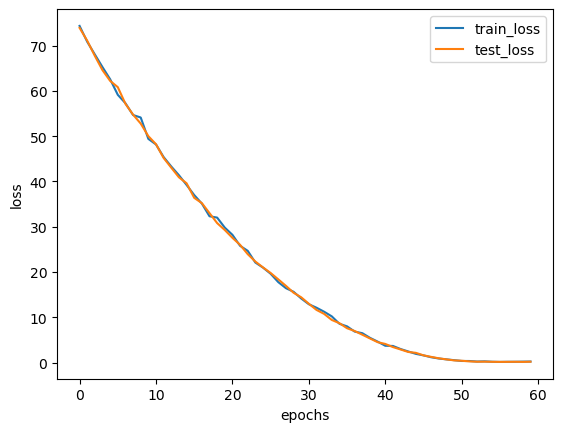

In [28]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.l1_h = 500
        self.l2_h = 500
        self.l3_h = 200
        self.l4_h = 1

        # Für Linear-Layer entschieden, da es in diesem Fall um Zusammenhänge je Zeile geht
        self.l1 = nn.Linear(X.shape[1], self.l1_h)
        self.l2 = nn.Linear(self.l1_h, self.l2_h)
        self.l3 = nn.Linear(self.l2_h, self.l3_h)
        self.l4 = nn.Linear(self.l3_h, self.l4_h)

        self.relu = nn.ReLU()

        # Batch Normalisierung nach jeder Layer, um extrem große Werte zu verhindern  
        self.b1 = nn.BatchNorm1d(self.l1_h)
        self.b2 = nn.BatchNorm1d(self.l2_h)
        self.b3 = nn.BatchNorm1d(self.l3_h)
        self.b4 = nn.BatchNorm1d(self.l4_h)

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.b1(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.b2(x)
        x = self.l3(x)
        x = self.relu(x)
        x = self.b3(x)
        x = self.l4(x)
        x = self.relu(x)
        x = self.b4(x)


        #x = self.relu(self.l5(self.relu(self.l4(self.relu(self.l3(self.relu(self.l2(self.relu(self.l1(x))))))))))

        return x
        
    
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Manuel Seed gesetzt, damit die Ergebnisse der verschiedenen Durchläufe des neuronalen Netzes besser vergleichbar werden 
torch.manual_seed(1234)

# 
model = Model()
optmizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
loss_fn = nn.MSELoss()
dataset = Dataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
schedular = torch.optim.lr_scheduler.CosineAnnealingLR(optmizer, T_max=20)
test_loader = torch.utils.data.DataLoader(Dataset(X_test, y_test), batch_size=256, shuffle=True)

epochs = 60
losses = []
test_losses = []

# 
for epoch in range(epochs):
   for xb, yb in data_loader:
       y_hat = model(xb)
       loss = loss_fn(y_hat, yb)
       loss.backward()
       optmizer.step()
       optmizer.zero_grad()
       #schedular.step()
   print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}")
   losses.append(loss.item())
   with torch.no_grad():
        for xb, yb in test_loader:
              y_hat = model(xb)
              test_loss = loss_fn(y_hat, yb)
        test_losses.append(test_loss.item())

# Einen Zwischenstand des Modells mit den errechneten Gewichten abspeichern
torch.save(model.state_dict(), "model_small_XXX.pt")

# Die beiden Listen Train- und Testloss als Grafen mit beschrifteten Achsen ausgeben 
plt.plot(losses, label="train_loss")
plt.plot(test_losses, label="test_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Bei aktuellen Einstellungen verringert sich Der Loss des Modells über 60 Epochen auf ungefähr 0,1. Dabei weichen Train und Testlos kaum voneinander ab

In [29]:
# An welchem Wochentag je intervall wie viel gekauft wurde
# An welchem Wochentag je StoreType wie viel gekauft wurde
# vorhersage von sales
# vorhersage von sales per customer